In [1]:
import json
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
import logging
logging.getLogger('matplotlib').setLevel(logging.INFO)  

In [2]:
from functions.data_handling import *
from functions.data_visualization_gdal import *
from functions.model_saving_loading import *
from functions.gis import *

In [3]:
%store -r RES 
%store -r WIDTH
%store -r HEIGHT
%store -r N_BANDS
%store -r N_CAT
%store -r TRAINING_YEARS 
%store -r TRAINING_SEASONS
%store -r MSK_PATH
%store -r MASK_FILE
%store -r MSK_RAW_PTH 
%store -r MSK_CLIP_PTH 
%store -r MAPPED_MSK_CLIP_PTH 
%store -r MSK_TILES_PTH
%store -r CLN_MSK_TILES_PTH
%store -r IMG_18_PATH 
%store -r IMG_18_FILE 
%store -r IMG_18_COMP_PTH 
%store -r IMG_18_CLIP_PTH 
%store -r IMG_18_NORM_PTH 
%store -r IMG_18_TILES_PTH 
%store -r CLN_IMG_18_TILES_PTH
%store -r IMG_19_PATH
%store -r IMG_19_FILE 
%store -r IMG_19_COMP_PTH
%store -r IMG_19_CLIP_PTH
%store -r IMG_19_NORM_PTH 
%store -r IMG_19_TILES_PTH
%store -r CLN_IMG_19_TILES_PTH 
%store -r MODELS_DIR 
%store -r TRAIN_SPLIT
%store -r TEST_SPLIT
%store -r DATASETS_DIR
%store -r MODELS_TO_LOAD_DIR 
%store -r INFERENCE_INPUT_DIR
%store -r TILE_SIZE
%store -r N_CLASSES
%store -r lgnd

RES = RES
WIDTH = WIDTH
HEIGHT = HEIGHT
N_BANDS = N_BANDS
N_CAT = N_CAT
TRAINING_YEARS = TRAINING_YEARS
TRAINING_SEASONS = TRAINING_SEASONS
MSK_PATH = MSK_PATH
MASK_FILE = MASK_FILE
MSK_RAW_PTH = MSK_RAW_PTH
MSK_CLIP_PTH = MSK_CLIP_PTH
MAPPED_MSK_CLIP_PTH = MAPPED_MSK_CLIP_PTH
MSK_TILES_PTH = MSK_TILES_PTH
CLN_MSK_TILES_PTH = CLN_MSK_TILES_PTH
IMG_18_PATH = IMG_18_PATH
IMG_18_FILE = IMG_18_FILE
IMG_18_COMP_PTH = IMG_18_COMP_PTH
IMG_18_CLIP_PTH = IMG_18_CLIP_PTH
IMG_18_NORM_PTH = IMG_18_NORM_PTH
IMG_18_TILES_PTH = IMG_18_TILES_PTH
CLN_IMG_18_TILES_PTH = CLN_IMG_18_TILES_PTH
IMG_19_PATH = IMG_19_PATH
IMG_19_FILE = IMG_19_FILE
IMG_19_COMP_PTH = IMG_19_COMP_PTH
IMG_19_CLIP_PTH = IMG_19_CLIP_PTH
IMG_19_NORM_PTH = IMG_19_NORM_PTH
IMG_19_TILES_PTH = IMG_19_TILES_PTH
CLN_IMG_19_TILES_PTH = CLN_IMG_19_TILES_PTH
MODELS_DIR = MODELS_DIR
TRAIN_SPLIT = TRAIN_SPLIT
TEST_SPLIT = TEST_SPLIT
DATASETS_DIR = DATASETS_DIR
MODELS_TO_LOAD_DIR = MODELS_TO_LOAD_DIR
INFERENCE_INPUT_DIR = INFERENCE_INPUT_DIR
TILE_SIZE = TILE_SIZE
N_CLASSES = N_CLASSES
lgnd = lgnd

## Mask clippping

In [4]:
outputBounds = get_overlay(gdal.Open(IMG_18_COMP_PTH), gdal.Open(MSK_RAW_PTH)) #, srs1="epsg:2169", srs2="epsg:32631")

print(f"outputBounds: {outputBounds}")

outputBounds: [48920.2, 57009.2, 106120.2, 138769.2]


In [5]:
delete_directory_or_file(MSK_CLIP_PTH) # Delete existing file(s) before uploading the newly created one(s)
clipped = gdal.Warp(
    MSK_CLIP_PTH,
    MSK_RAW_PTH,
    outputBounds=outputBounds,
    # outputBoundsSRS="epsg:2169",
    # srcSRS="epsg:32631", 
    # dstSRS="epsg:32631",    
    xRes=RES,
    yRes=RES,
    targetAlignedPixels=False,
)
clipped = None

Deleted file: ./inputs/inputs_10m/mask/mask_clipped.tif


## Legend loading

In [6]:
with open('legends/lc_2018_lgnd_5_cat.json') as json_file:
    LGND = json.load(json_file)
LGND = {int(k): v for k, v in LGND.items()}

print(LGND)
# 255: 0, #NAN
# 1: 1, #Buildings
# 2: 1, #Other construction area
# 3: 2, #Bare soil
# 6: 3, #Water
# 7: 4, #Trees
# 8: 4, #Bushes
# 91: 5, #Permanent herbaceous vegetation
# 92: 2, #Seasonal herbaceous vegetation
# 93: 2, #Vineyards

{255: 0, 1: 1, 2: 1, 3: 2, 6: 3, 7: 4, 8: 4, 91: 5, 92: 2, 93: 2}


## Mask checking

[  1   2   3   6   7   8  91  92  93 255]


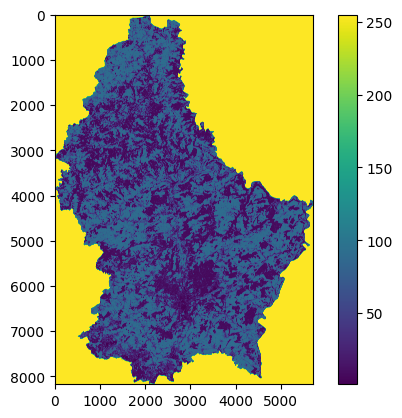

In [7]:
ds = gdal.Open(MSK_CLIP_PTH)
mask = ds.ReadAsArray()
print(np.unique(mask))
plt.imshow(mask, cmap='viridis')  # Choose a colormap for visualization
plt.colorbar()  # Add a colorbar to the plot
plt.show()   

## Mapping the initial categories values to the ones in the legend

In [8]:
mapped_mask = create_cat_from_pth(MSK_CLIP_PTH, LGND)
mapped_mask = mapped_mask.astype(np.int16)

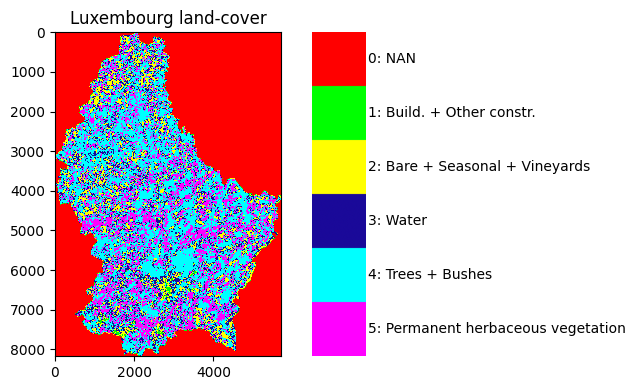

In [9]:
show_mask(mapped_mask, lgnd, 'Luxembourg land-cover')

## Uploading the newly mapped mask

In [10]:
delete_directory_or_file(MAPPED_MSK_CLIP_PTH) # Delete existing file(s) before uploading the newly created one(s)
upload_tif(out_file_pth=MAPPED_MSK_CLIP_PTH, arr=mapped_mask, old_file_pth=MSK_CLIP_PTH, EPSG_code=2169)

Deleted file: ./inputs/inputs_10m/mask/mapped_mask_clipped.tif
GeoTIFF file created successfully.


# Inputs prep 2018 Summer

## Image clipping 

In [11]:
delete_directory_or_file(IMG_18_CLIP_PTH) # Delete existing file(s) before uploading the newly created one(s)
clipped = gdal.Warp(
    destNameOrDestDS=IMG_18_CLIP_PTH,
    srcDSOrSrcDSTab= IMG_18_COMP_PTH,
    outputBounds=outputBounds,
    # outputBoundsSRS="epsg:2169",
    # srcSRS="epsg:32631", 
    # dstSRS="epsg:2169",
    xRes=RES,
    yRes=RES,
    targetAlignedPixels=False,
)
clipped=None

Deleted file: ./inputs/inputs_10m/image/2018/image_clipped_S_2018.tif


## Image normalization

In [12]:
delete_directory_or_file(IMG_18_NORM_PTH)
normalize_raster(in_pth=IMG_18_CLIP_PTH, out_pth=IMG_18_NORM_PTH)

Deleted file: ./inputs/inputs_10m/image/2018/image_normalized_S_2018.tif
starting normalization
185.5 4745.45751953125
processing band: 1
processing band: 2
processing band: 3
processing band: 4
processing band: 5
processing band: 6
processing band: 7
processing band: 8
processing band: 9
processing band: 10


# Inputs prep 2019 Summer

## Image clippping

In [13]:
delete_directory_or_file(IMG_19_CLIP_PTH) # Delete existing file(s) before uploading the newly created one(s)
clipped = gdal.Warp(
    destNameOrDestDS=IMG_19_CLIP_PTH,
    srcDSOrSrcDSTab= IMG_19_COMP_PTH,
    outputBounds=outputBounds,
    # outputBoundsSRS="epsg:2169",
    # srcSRS="epsg:32631", 
    # dstSRS="epsg:2169",
    xRes=RES,
    yRes=RES,
    targetAlignedPixels=False,
)
clipped=None

Deleted file: ./inputs/inputs_10m/image/2019/image_clipped_S_2019.tif


## Image normalization

In [14]:
delete_directory_or_file(IMG_19_NORM_PTH) # Delete existing file(s) before uploading the newly created one(s)
normalize_raster(in_pth=IMG_19_CLIP_PTH, out_pth=IMG_19_NORM_PTH)

Deleted file: ./inputs/inputs_10m/image/2019/image_normalized_S_2019.tif
starting normalization
186.0 4899.5
processing band: 1
processing band: 2
processing band: 3
processing band: 4
processing band: 5
processing band: 6
processing band: 7
processing band: 8
processing band: 9
processing band: 10


## Tiles creation

In [15]:
msk_tiles_folder_pths_list = []
img_tiles_folder_pths_list = []

### Mask tiles

In [16]:
delete_directory_or_file(MSK_TILES_PTH) # Delete existing file(s) before uploading the newly created one(s)
print('')
create_tiles(out_folder_pth=MSK_TILES_PTH, in_folder_pth=MAPPED_MSK_CLIP_PTH, width=WIDTH, height=HEIGHT)
msk_tiles_folder_pths_list.append(MSK_TILES_PTH)

Deleted directory and its contents: ./inputs/inputs_10m/mask/5_cat/128px/mask_tiles/

gdal_retile.py -ps 128 128 -targetDir ./inputs/inputs_10m/mask/5_cat/128px/mask_tiles/ ./inputs/inputs_10m/mask/mapped_mask_clipped.tif
0...10...20...30...40...50...60...70...80...90...100 - done.


### Image tiles

In [17]:
delete_directory_or_file(IMG_18_TILES_PTH) # Delete existing file(s) before uploading the newly created one(s)
print('')
create_tiles(out_folder_pth=IMG_18_TILES_PTH, in_folder_pth=IMG_18_NORM_PTH, width=WIDTH, height=HEIGHT)
img_tiles_folder_pths_list.append(IMG_18_TILES_PTH)

Deleted directory and its contents: ./inputs/inputs_10m/image/2018/5_cat/128px/image_tiles/

gdal_retile.py -ps 128 128 -targetDir ./inputs/inputs_10m/image/2018/5_cat/128px/image_tiles/ ./inputs/inputs_10m/image/2018/image_normalized_S_2018.tif
0...10...20...30...40...50...60...70...80...90...100 - done.


In [18]:
delete_directory_or_file(IMG_19_TILES_PTH) # Delete existing file(s) before uploading the newly created one(s)
print('')
create_tiles(out_folder_pth=IMG_19_TILES_PTH, in_folder_pth=IMG_19_NORM_PTH, width=WIDTH, height=HEIGHT)
img_tiles_folder_pths_list.append(IMG_19_TILES_PTH)

Deleted directory and its contents: ./inputs/inputs_10m/image/2019/5_cat/128px/image_tiles/

gdal_retile.py -ps 128 128 -targetDir ./inputs/inputs_10m/image/2019/5_cat/128px/image_tiles/ ./inputs/inputs_10m/image/2019/image_normalized_S_2019.tif
0...10...20...30...40...50...60...70...80...90...100 - done.


## Creating the list of references of cleaned tiles (mask tiles without NAN data) 

In [19]:
keep_lst_org_lists = get_no_nan_zero_tiles_refs(msk_tiles_folder_pths_list, img_tiles_folder_pths_list)

Number of tiles in initial folder: 2880


Processing Tiles: 100%|██████████| 2880/2880 [00:00<00:00, 4151.40it/s]


Number of tiles in cleaned folder: 1437
--------------------------------------------------------------------------------
Number of tiles in initial folder: 2880


Processing Tiles: 100%|██████████| 2880/2880 [00:02<00:00, 1231.89it/s]


Number of tiles in cleaned folder: 2879
--------------------------------------------------------------------------------
Number of tiles in initial folder: 2880


Processing Tiles: 100%|██████████| 2880/2880 [00:02<00:00, 1244.78it/s]

Number of tiles in cleaned folder: 2880
--------------------------------------------------------------------------------


In [20]:
keep_lst_org = find_common_elements(keep_lst_org_lists)
len(keep_lst_org)

1437

## Creating the folders (img and mask) with cleaned tiles

In [21]:
delete_directory_or_file(CLN_MSK_TILES_PTH)
delete_directory_or_file(CLN_IMG_18_TILES_PTH)
upload_cln_msk_tiles(out_folder_pth = CLN_MSK_TILES_PTH, in_folder_pth = MSK_TILES_PTH, ref_list=keep_lst_org)
upload_cln_img_tiles(out_folder_pth = CLN_IMG_18_TILES_PTH, in_folder_pth = IMG_18_TILES_PTH, ref_list=keep_lst_org)

Deleted directory and its contents: ./inputs/inputs_10m/mask/5_cat/128px/cln_mask_tiles/
Deleted directory and its contents: ./inputs/inputs_10m/image/2018/5_cat/128px/cln_image_tiles/


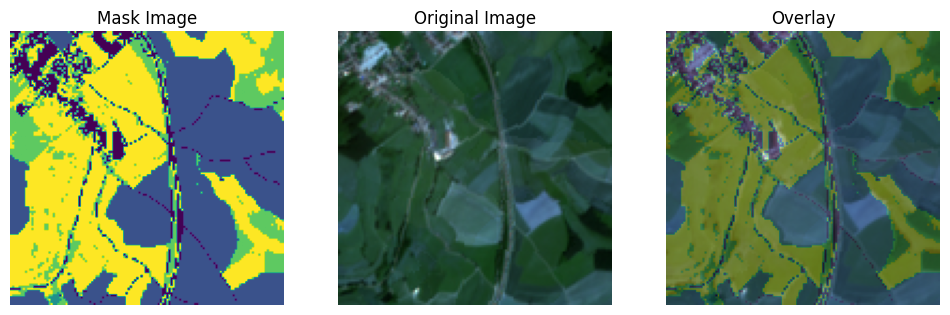

Mask classes: [1 2 3 4 5]
Mask shape: (128, 128)
Image shape: (128, 128, 10)


In [22]:
MSK_TO_COMPARE=f'inputs/inputs_{RES}m/mask/{N_CAT}/{WIDTH}px/cln_mask_tiles/mapped_mask_clipped_05_20.tif'
IMG_TO_COMPARE=f'inputs/inputs_{RES}m/image/{TRAINING_YEARS[0]}/{N_CAT}/{WIDTH}px/cln_image_tiles/image_normalized_{TRAINING_SEASONS[0]}_{TRAINING_YEARS[0]}_05_20.tif'

compare_from_pth(msk_pth=MSK_TO_COMPARE, img_pth=IMG_TO_COMPARE, msk_opacity=0.35, img_brightness_factor=2, season = False, period = 'winter')
# if the satellite image looks weird, make sure to have set the right 'season' parameter. If the satellite image includes multiple seasons, set the 'season' parameter to True and chose the period. Otherwise set the season parameter to False

## Creating the folders (img and mask) with cleaned tiles

In [23]:
delete_directory_or_file(CLN_IMG_19_TILES_PTH)
upload_cln_img_tiles(out_folder_pth = CLN_IMG_19_TILES_PTH, in_folder_pth = IMG_19_TILES_PTH, ref_list=keep_lst_org)

Deleted directory and its contents: ./inputs/inputs_10m/image/2019/5_cat/128px/cln_image_tiles/


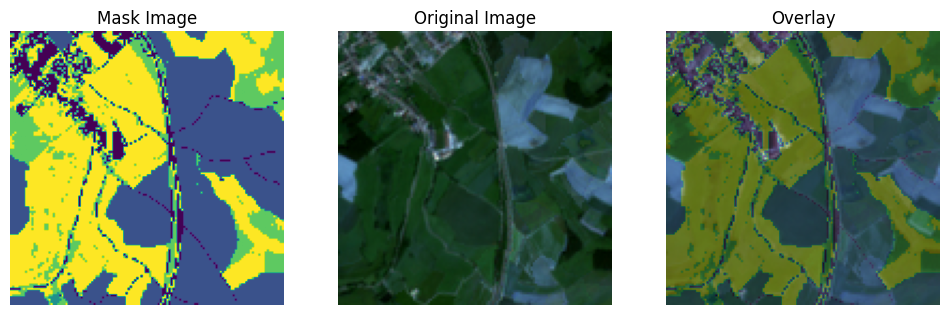

Mask classes: [1 2 3 4 5]
Mask shape: (128, 128)
Image shape: (128, 128, 10)


In [24]:
MSK_TO_COMPARE=f'inputs/inputs_{RES}m/mask/{N_CAT}/{WIDTH}px/cln_mask_tiles/mapped_mask_clipped_05_20.tif'
IMG_TO_COMPARE=f'inputs/inputs_{RES}m/image/{TRAINING_YEARS[1]}/{N_CAT}/{WIDTH}px/cln_image_tiles/image_normalized_{TRAINING_SEASONS[0]}_{TRAINING_YEARS[1]}_05_20.tif'

compare_from_pth(msk_pth=MSK_TO_COMPARE, img_pth=IMG_TO_COMPARE, msk_opacity=0.35, img_brightness_factor=2)

In [25]:
print(count_files_in_folder(CLN_MSK_TILES_PTH))
print(count_files_in_folder(CLN_IMG_18_TILES_PTH))
print(count_files_in_folder(CLN_IMG_19_TILES_PTH))

1437
1437
1437
